# CDR: High Level Turbine Design

> Author: Elias Aoubala

> Date: 21/04/2025

In [1]:
from turborocket.meanline.meanline_relations import TurbineStageDesign
from turborocket.fluids.fluids import IdealGas
from turborocket.profiling.Supersonic.supersonic_profile import SymmetricFiniteEdge
from turborocket.profiling.Supersonic.circular import inv_M_star, M_star
import numpy as np
import pandas as pd
import handcalcs.render

## 1 - Background

This document encapsulates the work towards the development of the second iteration of the turbine stage of the "Mermaidman and Barnacle Boy" turbopump being developed by the Open Turbopumps amature group.

This document highlights the high-level fluidic design and analyiss conducted for the turbine.

## 2 - High-Level Specifications

Based on the previous studies performed, the following key inputs have been used on the high-level turbine design:

| Parameter        | Value      | Justification                                                                                                       |
| ---------------- | ---------- | ------------------------------------------------------------------------------------------------------------------- |
| Shaft Speed      | 30,000 RPM | Based on the preliminary rotor dynamic analysis, advancing the shaft speed to 30,000 RPM was identified as feasible |
| Pump Power      | 4 kW       | This is the most up-to date pump power requirement                                                                  |

The following inputs from the gas-generator study have additionally been provided:

| Parameter                      | Value       | Justification                                                |
| ------------------------------ | ----------- | ------------------------------------------------------------ |
| Nominal Mixture Ratio          | 1           | Based on Sensitivity Study Conducted on Gas Generator Design |
| Inlet Pressure ($P_o$)         | 20e5        | Based on Sensitivity Study Conducted on Gas Generator Design |
| Inlet Temperature ($T_o$)      | 858 K       | Based on Sensitivity Study Conducted on Gas Generator Design |
| Specific Heat Capacity ($C_p$) | 8575 J/kg K | Based on Sensitivity Study Conducted on Gas Generator Design |
| Specific Heat Ratio ($\gamma$) | 1.164       | Based on Sensitivity Study Conducted on Gas Generator Design |
| Specific Gas Constant (R)      | 518.949 | Based on Sensitivity Study Conducted on Gas Generator Design |



For the sake of consistency, we will parameterise these inputs in an array as was previously shown.

In [762]:
dic_gg = {
    "P_cc": 2500000.0,
    "MR": np.float64(1.0),
    "T_o": np.float64(869.3134455786856),
    "Cp": np.float64(3660.915135137826),
    "gamma": np.float64(1.1651672213813036),
    "R": np.float64(518.9497005130706),
    "ox_stiffness": 1.0,
    "fu_stiffness": 1.0,
    "m_dot_t": 0.038654999999999995,
    "m_dot_o": np.float64(0.019327499999999997),
    "m_dot_f": np.float64(0.019327499999999997),
}

dic_gg_geom = {
    "CdA_ox": np.float64(3.077950794617968e-07),
    "CdA_fu": np.float64(3.083041756036666e-07),
    "A_fu": np.float64(7.707604390091664e-07),
    "A_ox": np.float64(6.155901589235936e-07),
    "Acc": 1.534339489187668e-05,
}

dic_rotor = {
    "N_shaft": 24e3,
    "u_cis": 0.13,
    "Rt": 15,
    "phi_n": 0.85,
    "alpha": 70,
    "delta_r": 2e-3,
    "N_nozzle": 3,
    "N_rotor": 15,
}

As we only have the power requirements for the pump, we must now derive the power requirements for the shaft, when considering the losses via the bearings and shaft seal.

## 3 - Power Requirements Considering Mechanical Losses

In the shaft design, we have two bearings being used, along with a mechanical seal.

Inorder to determine the losses, we will use `SKF` to estimate the resitive torques expected for both of these bearings.

To do so, we need a rough estimation of what the forces carried by the bearings will be.

A calculation was conducted in the `bearings.ipynb` document for the expected mechanical losses for the system, which was evaluated at approximately 1.6 kW.

This brings the total power requirement for the turbine to 5.6 kW.

We can take an additional 30% Margin against this power requirement, to derive a required turbine power of **7.28 kW**

In [763]:
dic_rotor["power"] = 7.28

## 4 - Initialising our Runnning Parameters

As this problem is an optimisation problem, we will manually initialise these until we reach a good operating point.

In [670]:
b = 15e-3
t = 5e-3

## 5 - Turbine Fluidic Design with Geometry Specification

Based on these inputs, we can derive the required turbine power accordingly - using our refined loss model.

The main parameter we will iterate on the GG mass flow rate untill we reach our target power. We will do an adjoint-esque iterative study until the power requirement is reached.

We will instantiate an inital error of 0

In [764]:
error = 0

### 5.1 - Optimisation Loop for System Power

We will use a relaxation factor of **0.4** for the adjoint solver based on the relative error from the target power.

In [787]:
relax = 0.4

dm = dic_gg["m_dot_t"]*error*relax

dic_gg["m_dot_t"] -= dm

In [788]:
print(f"Blade Chord Length: {b*1e3}")
print(f"Blade Spacing: {t*1e3}")

Blade Chord Length: 21.827297401257393
Blade Spacing: 9.82051492735344


In [789]:
fluid = IdealGas(
    p=dic_gg["P_cc"],
    t=dic_gg["T_o"],
    gamma=round(dic_gg["gamma"], 3),
    cp=dic_gg["Cp"],
    R=dic_gg["R"],
)

stage = TurbineStageDesign(gas=fluid, m_dot=dic_gg["m_dot_t"], omega=dic_rotor["N_shaft"], alpha=(90 - dic_rotor["alpha"]))

stage.set_operating_point(u_cis=dic_rotor["u_cis"], Rt=dic_rotor["Rt"], b=b, t=t, delta_r=dic_rotor["delta_r"], N=dic_rotor["N_nozzle"])

result = stage.solve_performance(phi_n=dic_rotor["phi_n"])

Mach Number: 2.3788960750536274
Mach Number: 1.9025668211850286
Current Error: 20.71263848474734 %
Current Error: 1.3549138499729088 %
Current Error: 0.10361992762318352 %
Current Error: 0.007837190929905728 %


We can get out power produced and calculate our error to repeat once again.

In [790]:
P = result["performance"]["Power"] * 1e-3

error = (P - dic_rotor["power"]) / dic_rotor["power"]

print(f"Relative Error: {error*1e2:.2f} %")

Relative Error: -0.00 %


**Final Gas Generator Mass Flow Rate**

In [791]:
%%render param

m_dot_t = dic_gg["m_dot_t"]*1e3 # g/s

<IPython.core.display.Latex object>

### 5.2 - Getting System Performance

We can now get an idea of the specific power of the turbine and the associated performance Metrics

In [770]:
performance_dic = result["performance"]
performance_dic = {k: [v] for k, v in performance_dic.items()}
performance_df = pd.DataFrame(performance_dic)

pressure_dic = result["pressure"]
pressure_dic = {k: [v] for k, v in pressure_dic.items()}
pressure_df = pd.DataFrame(pressure_dic)

velocity_dic = result["velocity"]
velocity_dic = {k: [v] for k, v in velocity_dic.items()}
velocity_df = pd.DataFrame(velocity_dic)

temperature_dic = result["temperature"]
temperature_dic = {k: [v] for k, v in temperature_dic.items()}
temperature_df = pd.DataFrame(temperature_dic)

geometry_dic = result["geometry"]
geometry_dic = {k: [v] for k, v in geometry_dic.items()}
geometry_df = pd.DataFrame(geometry_dic)

mach_dic = result["mach"]
mach_dic = {k: [v] for k, v in mach_dic.items()}
mach_df = pd.DataFrame(mach_dic)

angles_dic = result["angles"]
angles_dic = {k: [v] for k, v in angles_dic.items()}
angles_df = pd.DataFrame(angles_dic)

**Performance**

In [771]:
performance_df["Power (kW)"] = performance_df["Power"].multiply(1e-3)
performance_df["Torque (Nm)"] = performance_df["Power"] / (25000 * 2 *np.pi/60)

performance_df

,dh,eps,phi_r,phi_l,m_leakage,eta_l,phi,eta_h,zeta_eps,eta_o,Power,Power (kW),Torque (Nm)
0,1.013804e+06,0.078898,0.650651,0.269486,0.010417,0.730514,0.85,0.282785,0.020823,0.185756,7279.514067,7.279514,2.78057


As can be seen, we are getting an efficiency on the order of **45%** with a specific power of 987 kW/kg/s

This works out to a GG size of the following:

**Pressures**

In [772]:
pressure_df * 1e-5

,p_0,p_1,p_1o,p_1o_r,p_2o_r,p_2o
0,25.0,1.666667,10.5772,6.79658,2.92681,2.333562


**Temperatures**

In [773]:
temperature_df

,t_0,t_1,t_1o_r,t_2,t_2o
0,869.313446,669.407979,816.529529,754.246075,791.070762


**Geometry**

In [774]:
geometry_df["Nozzle Throat (mm)"] = [(dic_gg_geom["Acc"] / (dic_rotor["N_nozzle"]* np.pi))**(1/2) * 2 * 1e3]
geometry_df["Nozzle Exit (mm)"] = geometry_df["s_c"]*1e3
geometry_df["eps"] = geometry_df["A_1"] / geometry_df["A_0"]

throat_error = (geometry_df["A_0"][0] - dic_gg_geom["Acc"] )/ dic_gg_geom["Acc"]

print(f"Comparison of Throat Calculated using CEA: {throat_error*100:.1f} %")

geometry_df

Comparison of Throat Calculated using CEA: 5.5 %


,D_m,A_1,A_0,s_c,s_b,D_hub,D_tip,AR,Nozzle Throat (mm),Nozzle Exit (mm),eps
0,0.147308,0.000067,0.000016,0.005315,0.007815,0.1434,0.151215,0.35805,2.55185,5.315272,4.112829


**Mach**

In [775]:
mach_df

,m_star_c1,m_star_w1,m_star_w2,m_star_c2
0,1.737045,1.537585,1.000432,0.745535


**Angles**

In [776]:
90 -angles_df

,beta_1,beta_2,alpha_2
0,66.504234,89.51122,34.315713


**Velocities**

In [777]:
velocity_df

,u,c_1s,c_1,w_1,a_star_2,w_2,c_2,a_star_3
0,185.112345,1423.941118,1210.34995,1038.333265,675.301308,675.592729,519.479192,664.690252


## 6 - Profile Design

Here we can generate our turbine blade profile, by using the "profiling" submodule of the `turborocket` python package.

A reasonable blade leading edge has been assumed for this analysis.

A reverse computation is performed to evaluate for the inlet mach number, based on the inlet M_star number.

We will assume a given number of blades at this stage

In [778]:
M_i = inv_M_star(M_star=mach_df["m_star_w1"][0], gamma=fluid.get_gamma())

M_star_w = mach_df["m_star_w1"][0]

super = SymmetricFiniteEdge(
    beta_ei = (90 - angles_df["beta_1"][0]),
    beta_i = (90 - angles_df["beta_1"][0]), 
    M_i=M_i,  # Relative Mach Numbers Nominally
    M_u=1.65,
    M_l=1.12,
    m_dot=1,
    h=10e-3,
    t_g_rat=0.1,
    g_expand=0.1,
    le_angle=20,
    fluid = fluid,
)

super.prantl_meyer()

super.generate_turbine_profile()
super.get_performance()

Initial Solidity: 2.689373220334694
Final Solidity: 2.222622496144375


{'M_u_max': np.float64(1.9616449877937694),
 'M_u_margin': np.float64(0.18887575017804212),
 'M_l_min': np.float64(1.1184990644234003),
 'M_l_margin': np.float64(0.0013401210505355396),
 'M_e_max': np.float64(1.5373573750617366),
 'M_e_margin': np.float64(0.028311013890438833)}

We can now get the geometry sized

In [779]:
profile_geometry = super.size_geometry(D_m=geometry_df["D_m"][0], N=dic_rotor["N_rotor"])
b = profile_geometry["b"]
t = profile_geometry["t"]

print(f"Blade Spacing: {t*1e3:.2f} mm")
print(f"Blade Chord Lenght: {b*1e3:.2f} mm")

Blade Spacing: 9.82 mm
Blade Chord Lenght: 21.83 mm


We can plot the passage geometry

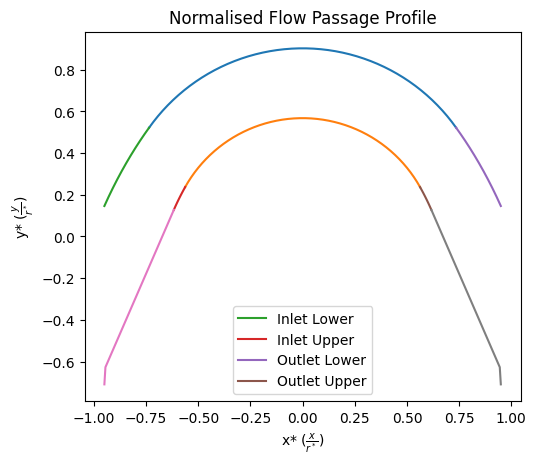

In [780]:
super.plot_passage()


Finally we can plot the scaled geometry

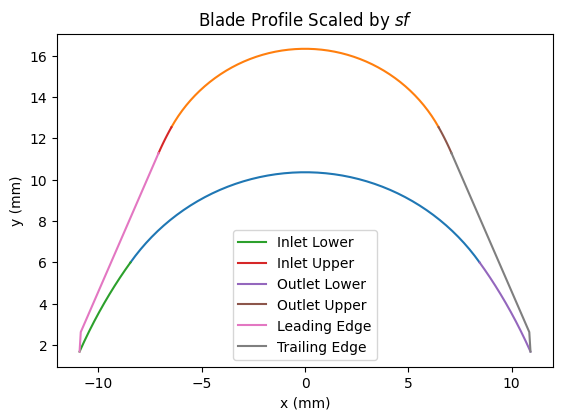

In [781]:
super.plot_scaled()

## 6 - Conclusion

The following key Parameters have been derived from this study:

| Parameter                | Value        |
| ------------------------ | ------------ |
| Gas Generator Mass Flow  | 28 g/s       |
| Shaft Speed              | 25,000 rpm   |
| Nozzle outlet Area       | 0.000044 m^2 |
| Nozzle Throat (GG Param) | 0.000011 m^2             |
|                          |              |

The following Power Requirement is present

In [22]:
%%render params

acceptable = (dic_rotor["power"] < performance_df["Power (kW)"][0])

Power = performance_df["Power (kW)"][0]

<IPython.core.display.Latex object>